<a href="https://colab.research.google.com/github/Avijit-D/hydration-essentials/blob/main/bottle_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading and Unzipping Dataset

In [4]:
!kaggle datasets download -d chethuhn/water-bottle-dataset


Dataset URL: https://www.kaggle.com/datasets/chethuhn/water-bottle-dataset
License(s): CC0-1.0
 89% 57.0M/64.2M [00:00<00:00, 81.0MB/s]
100% 64.2M/64.2M [00:00<00:00, 77.1MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('archive.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Dataset Partition

In [32]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [33]:
def get_dataset_partitions_tf(ds, train_split=0.75, val_split=0.125, test_split=0.125, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1, "Splits must sum to 1"

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

def load_images_from_directory(directory, image_size=(256, 256), batch_size=32):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory=directory,
        labels='inferred',
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size
    )
    return dataset

image_directory = '/content/archive'
dataset = load_images_from_directory(image_directory)

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")


Found 486 files belonging to 3 classes.
Train dataset size: 12
Validation dataset size: 2
Test dataset size: 2


# Image Preprocessing

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
# Resizing and Rescaling
resize_and_rescale = keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(256, 256),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [10]:
# Data Augmentation
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Train dataset size: 12
Validation dataset size: 2
Test dataset size: 2


# Model Building

In [34]:
# Importing libraries
import tensorflow as tf
from tensorflow import keras
import logging
logging.basicConfig(level=logging.ERROR, filename= "tensorflow.log", filemode="w")

from keras import models,layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [47]:
# Importing Keras models and layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation

In [48]:
input_shape = (32, 256, 256, 3)
num_classes = 3

model = Sequential([
    resize_and_rescale,
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation=None),
    BatchNormalization(),
    Activation('relu'),

    Dense(64, activation=None),
    BatchNormalization(),
    Activation('relu'),

    Dense(num_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

# Model Training

In [49]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [50]:
history = model.fit(train_ds,epochs=5,validation_data=val_ds)

Epoch 1/5
 9/12 [=====================>........] - ETA: 9s - loss: 0.8686 - accuracy: 0.6336 

KeyboardInterrupt: 

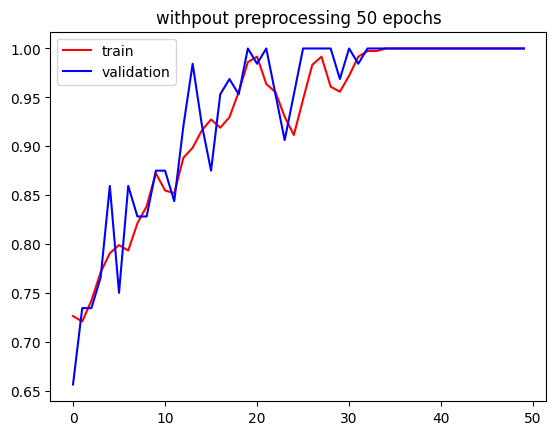

In [43]:
#withpout preprocessing 50 epoch
import matplotlib.pyplot as plt
plt.title('withpout preprocessing 50 epochs')
plt.plot(history. history['accuracy'], color='red' , label= 'train' )
plt.plot(history. history['val_accuracy'], color='blue' , label= 'validation')
plt.legend()
plt.show()

In [44]:
score = model.evaluate(test_ds)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 6s 981ms/step - loss: 4.8766e-04 - accuracy: 1.0000
Test loss: 0.00048766311374492943
Test accuracy: 1.0


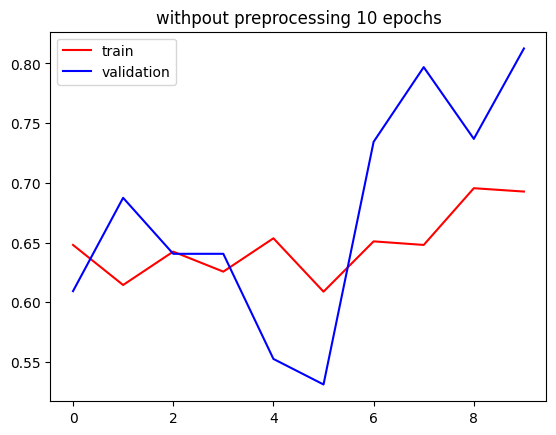

In [41]:
#withpout preprocessing
import matplotlib.pyplot as plt
plt.title('withpout preprocessing 10 epochs')
plt.plot(history. history['accuracy'], color='red' , label= 'train' )
plt.plot(history. history['val_accuracy'], color='blue' , label= 'validation')
plt.legend()
plt.show()


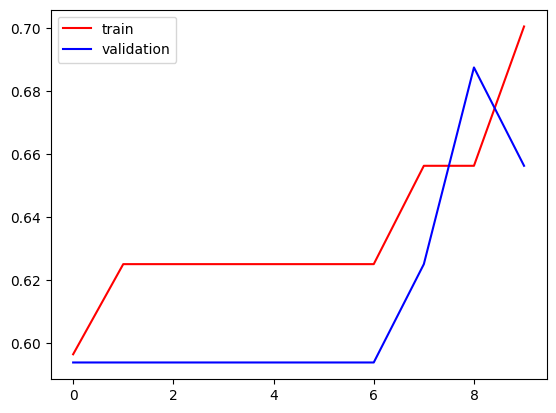

In [31]:
#Normal

import matplotlib.pyplot as plt

plt.plot(history. history['accuracy'], color='red' , label= 'train' )
plt.plot(history. history['val_accuracy'], color='blue' , label= 'validation')
plt.legend()
plt.show()